In [1]:
# -*- coding: utf-8 -*-
import re
import time
import datetime 
import operator
import numpy as np
import pandas as pd 
import collections
import unicodedata
import collections
import seaborn as sns
import collections
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import Counter
from datetime import datetime, date, timedelta
from IPython.display import Image


%matplotlib inline

pylab.rcParams['figure.figsize'] = 10,8

plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

In [275]:
reward_table = [
    [ -250 , -15000, -405 , -15000],
    [-309 , -15000, -400 , 405  ],
    [-262 , -15000, -255 , 400  ],
    [-231 , -15000, -77  , 255  ],
    [-61  , -15000, 0    , 77   ],
    [0    , -15000, 0    , 0    ],
    [0    , -15000, -15000, 0    ],
    [-325 , 250  , -452 , -15000],
    [-270 , 309  , -325 , 452  ],
    [-200 , 262  , -190 , 325  ],
    [-125 , 231  , -10  , 190  ],
    [-2   , 61   , 0    , 10   ],
    [0    , 0    , 0    , 0    ],
    [0    , 0    , -15000, 0    ],
    [-192 , 325  , -390 , -15000],
    [-169 , 270  , -285 , -390 ],
    [-105 , 200  , -132 , 285  ],
    [-10  , 125  , -5   , 132  ],
    [0    , 2    , 0    , 5    ],
    [0    , 0    , 0    , 0    ],
    [0    , 0    , -15000, 0    ],
    [-117 , 192  , -350 , -15000],
    [-67  , 169  , -235 , 350  ],
    [-8   , 105  , -26  , 235  ],
    [0    , 10   , 0    , 26   ],
    [0    , 0    , 0    , 0    ],
    [0    , 0    , 0    , 0    ],
    [0    , 0    , -15000, 0    ],
    [-38  , 117  , -250 , -15000],
    [0    , 67   , -148 , 250  ],
    [0    , 8    , -3   , 148  ],
    [0    , 0    , 0    , 3    ],
    [0    , 0    , 0    , 0    ],
    [0    , 0    , 0    , 0    ],
    [0    , 0    , -15000, 0    ],
    [0    , 38   , -195 , -15000],
    [0    , 0    , -193 , 195  ],
    [0    , 0    , -5   , 193  ],
    [0    , 0    , 0    , 5    ],
    [0    , 0    , 0    , 0    ],
    [0    , 0    , 0    , 0    ],
    [0    , 0    , -15000, 0    ],
    [-15000, 0    , -255 , -15000],
    [-15000, 0    , -190 , 255  ],
    [-15000, 0    , -8   , 190  ],
    [-15000, 0    , 0    , 8   ],
    [-15000, 0    , 0    , 0    ],
    [-15000, 0    , 0    , 0    ],
    [-15000, 0    , -15000, 0    ]
]; 

In [139]:
def action_is_allowed(learner, state, action):

    if (action == 0 and not(state > learner.num_states - learner.servo_num_states - 1)):
        return True
    elif (action == 1 and not(state < learner.servo_num_states)):
        return True
    elif (action == 2 and not((state%learner.servo_num_states) == (learner.servo_num_states-1))):
        return True
    elif (action == 3 and not(state%learner.servo_num_states==0)):
        return True
    else:
        return False

In [298]:
class QLearner(object):
    def __init__(self, 
                 servo_num_states, 
                 num_actions, 
                 alpha, 
                 gamma, 
                 random_action_decay_rate, 
                 warm_up_period, 
                 action_penalty,
                 negative_reward_coef):
        
        self.servo_num_states = servo_num_states
        self.num_states = servo_num_states**2
        self.num_actions = num_actions
        self.alpha = alpha
        self.gamma = gamma
        self.random_action_rate = 1
        self.random_action_decay_rate = random_action_decay_rate
        self.warm_up_period = warm_up_period
        self.state = 0
        self.action = 0
        self.action_penalty = action_penalty
        #self.qtable = np.random.uniform(low=-1, high=1, size=(self.num_states, self.num_actions))
        self.qtable = np.zeros((self.num_states, self.num_actions))
        self.num_iteration = 0
        self.last_reward = 0
        self.negative_reward_coef = negative_reward_coef
        
    def set_initial_state(self, action):
        """
        @summary: Sets the initial state and returns an action
        @param state: The initial state
        @returns: The selected action
        """
        self.state = int(self.num_states/2)
        self.action = action #self.qtable[state].argsort()[-1]
        
    def get_next_state(self):
        
        next_state = None
        
        if (self.action == 0 and action_is_allowed(self, self.state, self.action)): 
            next_state = self.state + self.servo_num_states
        elif (self.action == 1 and action_is_allowed(self, self.state, self.action)):
            next_state = self.state - self.servo_num_states
        elif (self.action == 2 and action_is_allowed(self, self.state, self.action)):
            next_state = self.state + 1
        elif (self.action == 3 and action_is_allowed(self, self.state, self.action)):
            next_state = self.state - 1 
        else:
            next_state = self.state;
            
        return next_state
        
    def move(self, state_prime, reward):
        """
        @summary: Moves to the given state with given reward and returns action
        @param state_prime: The new state
        @param reward: The reward
        @returns: The selected action
        """
        alpha = self.alpha
        gamma = self.gamma
        state = self.state
        action = self.action
        qtable = self.qtable
        action_prime = -1
        
#         if self.state == state_prime: 

#             while not self.action_is_allowed(action_prime):
#                 action_prime = np.random.randint(0, self.num_actions)
            
#             self.action = action_prime
            
        if False:
            print 'yo'
            
        else: 
            
            choose_random_action = (1 - self.random_action_rate) <= np.random.uniform(0, 1)

            if choose_random_action:
#                 while not(action_is_allowed(self, state_prime, action_prime)): 
                action_prime = np.random.randint(0, self.num_actions)
            else:
                ordered_action_list = self.qtable[state_prime].argsort()
                best_choice_index = -1
#                 while not(action_is_allowed(self, state_prime, action_prime)):
                action_prime = ordered_action_list[best_choice_index]
#                     best_choice_index -= 1

            if self.num_iteration > self.warm_up_period and self.random_action_rate > 0.0: # warm up period is over
                self.random_action_rate *= self.random_action_decay_rate
                    
            
            if reward < 0 and np.abs(reward) < 15000:
                reward = reward * self.negative_reward_coef
                
            qtable[state, action] = qtable[state, action] + alpha * (reward + gamma * qtable[state_prime, action_prime] - qtable[state, action])

            self.state = state_prime
            self.action = action_prime    
            self.qtable = qtable

In [379]:
def get_final_reward(learner, reward_table, training_iteration, num_simulation):
    
    reward_list = []
    
    for simulation in xrange(num_simulation):
        
        temp_reward_list = []
    
        for iteration_step in xrange(training_iteration):
            
            reward = reward_table[learner.state][learner.action] - learner.action_penalty

            #if iteration_step >= learner.warm_up_period: # we don't take into acount the warm up period reward
            temp_reward_list.append(reward)

            next_state = learner.get_next_state()


            learner.move(next_state, reward)
            learner.num_iteration += 1 

        reward_list.append(np.sum(temp_reward_list))

    return np.mean(reward_list)
    
    

In [380]:
from hyperopt import hp, fmin, tpe, hp, STATUS_OK, Trials

best_score = np.inf

def score(params):
    
    global best_score    

    learner = QLearner(servo_num_states=7,
                       num_actions=4,
                       alpha=float(params['alpha']),
                       gamma=float(params['gamma']),
                       random_action_decay_rate=float(params['random_action_decay_rate']),
                       warm_up_period=int(params['warm_up_period']),
                       action_penalty=50,
                       negative_reward_coef = 1)#float(params['negative_reward_coef']))

    learner.set_initial_state(action=0)

    loss = - get_final_reward(learner, reward_table, training_iteration=10000, num_simulation=10) # negative because we want to minimize loss
    
    if loss < best_score: 
        print "Searching...", 
        print "New best score: {0:.2f}".format(loss), 
        print params 
        print 
        best_score = loss

    return {'loss': loss, 'status': STATUS_OK}
    
def optimize(trials):
        
    space = {
             'alpha': hp.uniform('alpha', 0.1, 1),
             'gamma': hp.uniform('gamma', 0.1, 1),
             'random_action_decay_rate': hp.uniform('random_action_decay_rate', 0.5, 1),
             'warm_up_period': hp.quniform('warm_up_period', 1, 400, 1),
             #'negative_reward_coef': hp.quniform('negative_reward_coef', 1, 2, 1)
            }

    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=150)

    print '------------------------' 
    print "Done."
    print "Best parameter setting:", best
    return best

In [381]:
%%time

#Trials object where the history of search will be stored
trials = Trials()

best_params = optimize(trials)

Searching... New best score: 553949.40 {'alpha': 0.4422892315453215, 'gamma': 0.5312250444805451, 'random_action_decay_rate': 0.5124895985883032, 'warm_up_period': 313.0}

Searching... New best score: 545041.20 {'alpha': 0.5805525143520612, 'gamma': 0.30650790777435416, 'random_action_decay_rate': 0.6100415578257595, 'warm_up_period': 174.0}

Searching... New best score: 534472.10 {'alpha': 0.3009508519283511, 'gamma': 0.8693742681332928, 'random_action_decay_rate': 0.6838204414940915, 'warm_up_period': 134.0}

Searching... New best score: 478837.80 {'alpha': 0.6107248268701401, 'gamma': 0.9990163565105135, 'random_action_decay_rate': 0.5734931484813793, 'warm_up_period': 180.0}

Searching... New best score: 238962.70 {'alpha': 0.7105635626684819, 'gamma': 0.9887997708441287, 'random_action_decay_rate': 0.50466195727458, 'warm_up_period': 232.0}

Searching... New best score: 229672.50 {'alpha': 0.8508856959737361, 'gamma': 0.9875492108585279, 'random_action_decay_rate': 0.7646170596733

100%|██████████| 1/1 [00:00<00:00, 14.81it/s]


3
4
11
18
17
10
3
4
11
18
17
10
3
4
5
12
11
18
17
10
3
4
11
18
17
10
3
4
11


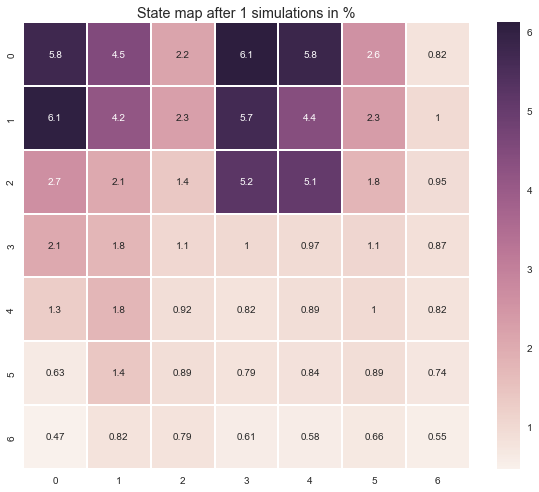

In [425]:
def crawling_simulation(params, reward_table, training_iteration = 3800, num_simulation = 1):
    
    state_vector = np.zeros(49)
    action_vector = np.zeros(4)
    
    for simulation in tqdm(xrange(num_simulation)):
        
        learner = QLearner(servo_num_states = 7,
                           num_actions=4,
                           alpha=float(params['alpha']),
                           gamma=float(params['gamma']),
                           random_action_decay_rate=float(params['random_action_decay_rate']),
                           warm_up_period=int(params['warm_up_period']),
                           action_penalty=50,
                           negative_reward_coef= 1) #float(params['action_penalty']))

        learner.set_initial_state(action=0)

        stop = False
    
        for iteration_step in xrange(training_iteration):
            
#             if learner.num_iteration == 1000:
#                 print learner.qtable[0]

            
            state_vector[learner.state] += 1
            action_vector[learner.action] += 1 
            
#             if iteration_step - 1 == learner.warm_up_period and simulation == 0:
#                 #print learner.state, learner.action, learner.qtable[learner.state]
#                 print learner.qtable
                
#             if iteration_step == 9980  and simulation == 0:
#                 #print learner.state, learner.action, learner.qtable[learner.state]
#                 print learner.qtable
                
            if iteration_step > training_iteration-30 and simulation == 0:
                print learner.state # , learner.action, learner.qtable[learner.state]
#                 print learner.qtable
                
            reward = reward_table[learner.state][learner.action] - learner.action_penalty
            next_state = learner.get_next_state()
            
#             dup = False
#             if next_state == learner.state:
#                 dup = True
#                 print iteration_step, next_state, learner.action, reward, 

            learner.move(next_state, reward)
            learner.num_iteration += 1 
#             if dup:
#                 print next_state
#                 print learner.qtable[next_state]
#                 print '----'

        
    normalize_state_vector = (state_vector/np.sum(state_vector)) * 100.
    state_map = pd.DataFrame(normalize_state_vector.reshape(learner.servo_num_states, -1))
    sns.heatmap(state_map, linewidths=1, annot=True)
    plt.title('State map after {} simulations in %'.format(num_simulation))
    
    normalize_action_vector = (action_vector/np.sum(action_vector)) * 100.
    
    #print normalize_action_vector
    
    return learner


# best_params = {'alpha': 0.40619963352672517, 
#                'random_action_decay_rate': 0.8189717113594237, 
#                'gamma': 0.9760578814233064, 
#                'warm_up_period': 341.0}
# best_params = {'warm_up_period': 363.0, 
#                'negative_reward_coef': 1.657585408801534, 
#                'gamma': 0.9744212450698116, 
#                'random_action_decay_rate': 0.7206861521993938, 
#                'alpha': 0.7199800066939188}
best_params = {'alpha': 0.9613645426995369, 
               'random_action_decay_rate': 0.6862739427670339, 
               'gamma': 0.9680926035857673, 
               'warm_up_period': 65.0}

learner = crawling_simulation(best_params, reward_table)